# Actor-Critic Algorithm
In this notebook, you'll code The Actor-Critic Algorithm from scratch: .

Actor-Critic algorithm is a *Policy-based method* that aims to reduce the variance of the Reinforce algorithm and train our agent faster and better by using a combination of Policy-Based and Value-Based methods


To test its robustness, we're going to train it in Cartpole-v1 environment

## Import the packages

In [1]:
%pip install swig
%pip install gymnasium[box2d]
%pip install gymnasium

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.6 MB 2.8 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.6 MB 1.6 MB/s eta 0:00:02
   ---------------- ----------------------- 1.0/2.6 MB 1.4 MB/s eta 0:00:02
   -------------------- ------------------- 1.3/2.6 MB 1.5 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.6 MB 1.3 MB/s eta 0:00:01
   -------------------------------- ------- 2.1/2.6 MB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-win_amd64.whl size=439816 sha256=58dced29b9fcafab91186957a7944170af9a5ad6529369bb1b3fb70ea603853

In [2]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gymnasium as gym


## Check if we have a GPU
- Let's check if we have a GPU `device:cuda0`

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Agent: Playing CartPole-v1 🤖
### The CartPole-v1 environment

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

So, we start with CartPole-v1. The goal is to push the cart left or right **so that the pole stays in the equilibrium.**

The episode ends if:
- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

We get a reward 💰 of +1 every timestep the Pole stays in the equilibrium.

In [6]:
#env_id = "CartPole-v1"
env_id="LunarLander-v3"
# Create the env
env = gym.make(env_id)


# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

## Let's build the A2C algo


In [7]:
#Using a neural network to learn our actor (policy) parameters

class Actor(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):

        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [8]:
#Using a neural network to learn state value
class Critic(nn.Module):

    #Takes in state
    def __init__(self, s_size, h_size):
        super(Critic, self).__init__()

        # two fully connected layers
        # add code here
        # add code here
        self.fc1 = nn.Linear(s_size, h_size)  # Input layer
        self.fc2 = nn.Linear(h_size, 1)       # Output layer

    def forward(self, x):

        #input layer
        x = self.fc1(x)  # Input layer

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.fc2(x)

        return state_value


# Building the parts of our algorithm #
The main steps for building a A2C Algo are:
1. Generates a trajectory
2. Compute the discounted returns
3. Standardization of the returns
4. Train critic network
5. Train actor network



In [9]:
def generate_trajectory(actor, critic, max_t):
        saved_log_probs = []
        rewards = []
        state_values=[]

        state, _ = env.reset()
        for t in range(max_t):
            state=torch.from_numpy(state).float().unsqueeze(0).to(device)

            action, log_prob = actor.act(state) # add code here

            # get the state value from th critic network
            state_val= critic(state) # add code here

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # add te obtained results to their relative lists ==> saved_log_probs, rewards, state_values

            # add code here
            # add code here
            # add code here
            saved_log_probs.append(log_prob)
            rewards.append(reward)
            state_values.append(state_val)

            state=next_state

            if done:

                break

        return  saved_log_probs, rewards, state_values

In [10]:
def computer_cumulative_reward(rewards, max_t,gamma):

        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        for t in range(n_steps)[::-1]:
          disc_return_t = (returns[0] if len(returns)>0 else 0)
          returns.appendleft( rewards[t]+gamma*disc_return_t)
        return returns

In [11]:
def returns_standardization(returns):
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        return returns

In [12]:

def train_actor(actorOptimizer,saved_log_probs, returns,state_values):


        state_values= torch.stack(state_values).squeeze()

        #calculate Advantage for actor
        advantages = returns - state_values  # add code here

        #convect the advantages to a tensor
        advantages = advantages.detach()  # add code here

        actor_loss = []
        # compute the actor loss
        # add code here
          
        for log_prob, advantage in zip(saved_log_probs, advantages):
                actor_loss.append(-log_prob * advantage)  # Negative log likelihood scaled by advantage


        actor_loss = torch.cat(actor_loss).sum()
        # Backpropagate actor
        actorOptimizer.zero_grad()
        actor_loss.backward()
        actorOptimizer.step()



In [13]:

def train_critic(criticOptimizer, returns,state_values):
        state_values= torch.stack(state_values).squeeze()
        returns = torch.tensor(returns).float().to(device)
        critic_loss= F.mse_loss(state_values, returns)  # add code here

        # Backpropagate crtic
        criticOptimizer.zero_grad()
        critic_loss.backward()
        criticOptimizer.step()


## Merge all functions into the Actor_Critic method ##

You will now see how the overall **A2C Algo** is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [14]:
def Actor_Critic(actor,critic, actorOptimizer,criticOptimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes+1):

        # Generate an episode
        saved_log_probs, rewards, state_values = generate_trajectory(actor, critic, max_t)  # Generate Trajectory #add code here
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # calculate the return
        returns= computer_cumulative_reward(rewards,max_t,gamma)

        ## standardization of the returns is employed to make training more stable
        returns=returns_standardization(returns)

        # Train the Critic network
        #add code here
        train_critic(criticOptimizer, returns, state_values) # Train critic
        # Train the Actor network
        #add code here
        train_actor(actorOptimizer, saved_log_probs, returns, state_values) # Train actor



        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

##  Train it
- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.
- You can change the training parameters (and should 😉)

In [23]:
cartpole_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 2500,
    "n_evaluation_episodes": 10,
    "max_t": 2500,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}
print(env_id)

LunarLander-v3


In [16]:
# Create actor and place it to the device
cartpole_actor = Actor(s_size, a_size, cartpole_hyperparameters["h_size"]).to(device) #add code here

cartpole_actorOptimizer = optim.Adam(cartpole_actor.parameters(), lr=cartpole_hyperparameters["lr"]) #add code here

In [17]:
# Create critic and place it to the device
cartpole_critic =  Critic(s_size, cartpole_hyperparameters["h_size"]).to(device) #add code here
cartpole_criticOptimizer = optim.Adam(cartpole_critic.parameters(), lr=cartpole_hyperparameters["lr"]) #add code here

In [24]:
scores = Actor_Critic(cartpole_actor,
                   cartpole_critic,cartpole_actorOptimizer,cartpole_criticOptimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)

C:\Users\friha\AppData\Local\Temp\ipykernel_24528\820202036.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns).float().to(device)


Episode 100	Average Score: 74.73
Episode 200	Average Score: 134.96
Episode 300	Average Score: 150.17
Episode 400	Average Score: 78.21
Episode 500	Average Score: 111.79
Episode 600	Average Score: 140.71
Episode 700	Average Score: 124.08
Episode 800	Average Score: 121.73
Episode 900	Average Score: 133.80
Episode 1000	Average Score: 132.74
Episode 1100	Average Score: 130.12
Episode 1200	Average Score: 125.20
Episode 1300	Average Score: 117.91
Episode 1400	Average Score: 101.63
Episode 1500	Average Score: 100.02
Episode 1600	Average Score: 63.01
Episode 1700	Average Score: -8.58
Episode 1800	Average Score: 28.92
Episode 1900	Average Score: 138.47
Episode 2000	Average Score: 80.79
Episode 2100	Average Score: 116.73
Episode 2200	Average Score: 130.56
Episode 2300	Average Score: 121.28
Episode 2400	Average Score: 106.88
Episode 2500	Average Score: 150.26


In [25]:
scores= pd.Series(scores, name="scores_Actor")
scores.describe()

count    2500.000000
mean      108.244372
std        88.441778
min      -404.547675
25%        53.609606
50%       118.598125
75%       158.702401
max       294.787976
Name: scores_Actor, dtype: float64

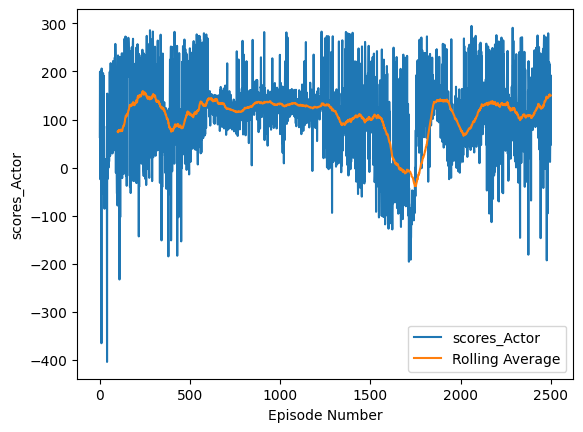

In [26]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="scores_Actor")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_Actor")